In [73]:
import matplotlib.pyplot as plt
import numpy as np
from filterpy.gh import GHFilter
import filterpy.kalman as kf

In [82]:
num_data = 100
outlier_coef = 0.2
noise = np.random.randn(num_data)*0.1
x = np.linspace(0, 1, num_data)

y = x + noise

outlier_index = np.random.choice(num_data, int(num_data*outlier_coef))
print(outlier_index.dtype)
y[outlier_index] += np.random.randn(outlier_index.shape[0])*5

int64


In [83]:
f = GHFilter(x=0., dx=0., dt=1., g=.01, h=.01)
gh_results = []
for t in range(num_data):
    sx, sdx = f.update(z=y[t])
    gh_results += [sx]
gh_results = np.array(gh_results)

In [84]:
kf_results = []
sx = 0
P = 1.0
Q = 1.0
R = 100.0
for t in range(num_data):
    sx, P = kf.predict(x=sx, P=P, u=0.0, Q=Q)
    sx, P = kf.update(x=sx, P=P, z=y[t], R=R)
    kf_results += [sx]
kf_results = np.array(kf_results)

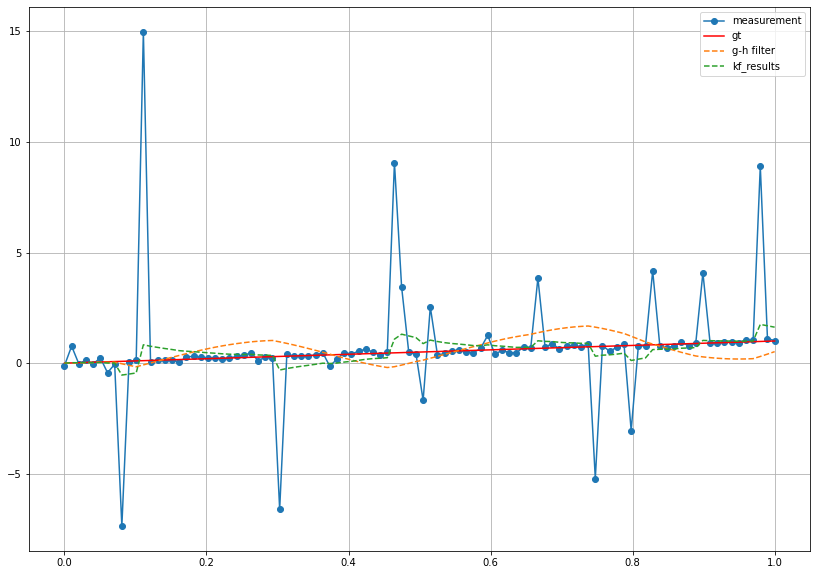

In [85]:
# %matplotlib qt
plt.rcParams["figure.figsize"] = (14,10)
plt.plot(x,y,"-o")
plt.plot(x,x,"r-")
plt.plot(x, gh_results,"--")
plt.plot(x, kf_results,"--")
plt.grid(True)
plt.legend(["measurement", "gt", "g-h filter", "kf_results"])
plt.show()

# Self-Contained KF

In [44]:
import math
import numpy as np
from numpy.random import randn

def compute_dog_data(z_var, process_var, count=1, dt=1.):
    "returns track, measurements 1D ndarrays"
    x, vel = 0., 1.
    z_std = math.sqrt(z_var) 
    p_std = math.sqrt(process_var)
    xs, zs = [], []
    for _ in range(count):
        v = vel + (randn() * p_std)
        x += v*dt        
        xs.append(x)
        zs.append(x + randn() * z_std)        
    return np.array(xs), np.array(zs)

In [45]:
from filterpy.common import Q_discrete_white_noise

dt = 1. # time step
R_var = 10
Q_var = 0.01
x = np.array([[10.0, 4.5]]).T
P = np.diag([500, 49]) #state cov
F = np.array([[1, dt],
              [0, 1]]) #linear state equation X = FX + BU
H = np.array([[1., 0.0]]) #measurement function y = Hx
R = np.array([[R_var]]) # measurement uncertainty
Q = Q_discrete_white_noise(dim=2, dt=dt, var=Q_var) #transitiion uncertainty

In [46]:
from scipy.linalg import inv

count = 50
track, zs = compute_dog_data(R_var, Q_var, count) #simulate

xs = []
cov = []

for z in zs: #measurements
    #predict
    x = F @ x #x_k|k-1 prior
    P = F @ P @F.T + Q #P_k|k-1
    
    #update
    S = H@P@H.T + R
    K = P@H.T@inv(S)
    y = z- H @ x #residual
    x += K@y #x_k|k posterior
    P = P- K@H@P #P_k|k , numerically stable -> (I - KH)P(I - KH).T + KRK.T
    
    xs.append(x)
    cov.append(P)
xs = np.array(xs)
cov = np.array(cov)

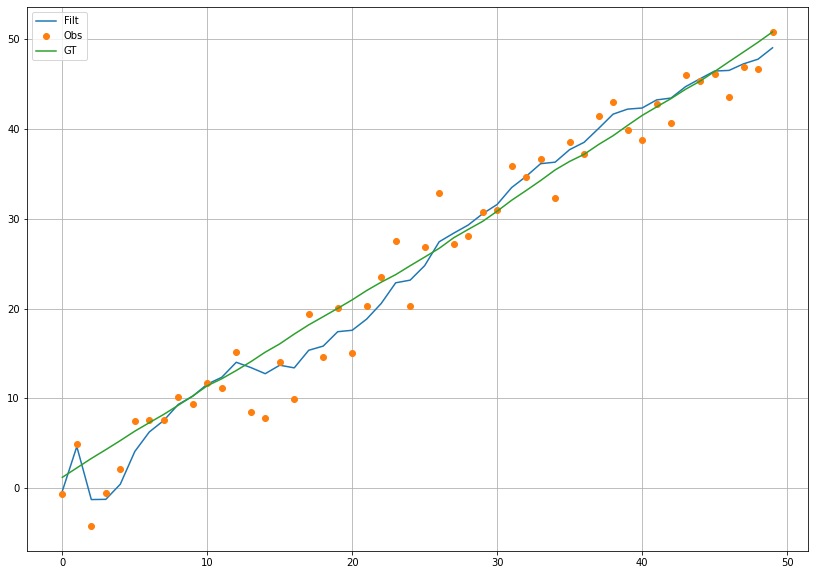

In [55]:
plt.plot(xs[:, 0])
plt.plot(zs,"o")
plt.plot(track)
plt.legend(["Filt", "Obs", "GT"])
plt.grid(True)
plt.show()

# self-contained UKF $\rightarrow$ LGUKF

In [66]:
import manifpy as manif
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (14, 10)
# plt.rcParams.keys()

In [7]:
T_k_1 = manif.SE3.Random()
v_k_1 = manif.SE3Tangent.Random()

In [8]:
J_T = np.zeros((6,6))
J_v = np.zeros((6,6))

In [9]:
T_k_k_1 = T_k_1.rplus(v_k_1, J_T, J_v)

In [10]:
#check J_T = Ad(Exp(v_{k-1})) ^ -1
(J_T == (v_k_1.exp()).inverse().adj()).all()

True

In [11]:
#paper 68, 69 check locality in manifold
tau = manif.SE3Tangent.Random()/10.0 # local perturbation
# equation 68
print((v_k_1 + tau).exp().coeffs())
print(v_k_1.exp() * (J_v @ tau).exp())

[ 0.56899837 -0.93587859  0.5095591   0.09638598  0.98582185  0.02507464
  0.13504181]
  0.56083 -0.935777  0.515907 0.0990367  0.984594 0.0250689  0.141908


In [358]:
"""
constant velocity model
"""
sigma_scale = 10.0 #m/s, rad/s

class SE3EKF:
    def __init__(self, dt, init_state, init_state_var, process_noise, measurement_noise):
        self.T = init_state[0] # list [T, v]
        self.v = init_state[1]
        self.P = np.diag(init_state_var) # concentrated gaussian tangent space gaussian
        self.process_cov = np.diag(process_noise)
        self.N = np.diag(measurement_noise)
        self.dt = dt
        
        J_T = np.zeros((6,6))
        J_v = np.zeros((6,6))
        self.H = np.block([np.eye(6), np.zeros((6,6))])
        
        self.sigma = (np.ones(6) * sigma_scale * dt)**2
        self.epsilon = np.ones(6)
        
    def _predict(self):
        #compute x_bar P_bar (prior of mean and cov)
        J_T = np.zeros((6,6))
        J_v = np.zeros((6,6))
        
        self.T = self.T.rplus(self.v * self.dt, J_T, J_v) #T <- T*Exp(v)
        self.v = self.v #v <- v
        
        F = np.block([[J_T, J_v* self.dt],
                      [np.zeros((6,6)), np.eye(6)]])
        Q = np.block([[J_v @ self.process_cov @ J_v.T * self.dt**2, self.process_cov @ J_v.T * self.dt],
                      [J_v @ self.process_cov * self.dt, self.process_cov]]) # 12 x 12
        
        self.P = F @ self.P @ F.T + Q 
#         print(self.T)
    def _update(self, measurement):
        z = (measurement - self.T).coeffs() # innovation
        z_clip = np.clip(z, -np.sqrt(self.sigma), np.sqrt(self.sigma))
        Z = self.H @ self.P @ self.H.T + self.N
        K = self.P @ self.H.T @ np.linalg.inv(Z) # near-optimal kalman gain
        
        #update x, P (posterior)
        dx = K @ z_clip
        
        self.T = self.T + manif.SE3Tangent(dx[:6])
        self.v = manif.SE3Tangent(self.v.coeffs() + dx[6:])
#         print(dx)
        
        self.P = self.P - K @ Z @ K.T
        
        self.dynamic_clip_update(z)
        
        return (self.T, self.v), self.P
    
    def dynamic_clip_update(self, z):
        lambda1 = np.array([0.7, 0.7, 0.7, 0.1, 0.1, 0.1])
        lambda2 = np.ones(6) * 0.5
        
#         gamma1 = np.ones(6) * 0.5
        gamma2 = np.ones(6) * 1
        
        self.sigma = lambda1 * self.sigma + gamma2 * self.epsilon * np.exp(-self.epsilon)
        self.epsilon = lambda2 * self.epsilon + gamma2 * z**2
        
        

In [359]:
#simulation data
T0 = manif.SE3(np.array([0,0,0,1,0,0,0]))
time_step = 1000
dt = 0.001
# constant_velocity = np.ones(6)
# constant_accel = np.ones(6)*0.01
vf = np.array([1.0, 1.0, 1.0, np.pi, np.pi, np.pi])
noise_std = np.ones(6) * 0.1

measurements = [T0]
real_datas = [T0.coeffs()]
track_coeff = [T0.coeffs()]
T = T0
outlier_level = 1000
velocity_datas = []
for t in range(time_step):
    constant_velocity = -4*vf/float(time_step)/float(time_step) * t * (t - time_step)
    if t%100==0 and t!=0:
        noise_level = outlier_level*noise_std
    else:
        noise_level = noise_std
        
    T = T + manif.SE3Tangent(constant_velocity*dt) 
    measurements.append(T + manif.SE3Tangent(np.random.randn(6)*noise_level))
    real_datas.append(measurements[-1].coeffs())
    track_coeff += [T.coeffs()]
    velocity_datas += [constant_velocity]
track_coeff = np.vstack(track_coeff)
real_datas = np.vstack(real_datas)
velocity_datas = np.vstack(velocity_datas)

In [360]:
init_state_var = np.array([0.1, 0.1, 0.1,
                           0.01, 0.01, 0.01,
                           1.0, 1.0, 1.0,
                           1.0, 1.0, 1.0])**2 # 12 state 
process_noise = 10*np.array([0.01, 0.01, 0.01, 0.001, 0.001, 0.001])**2 # velocity propagation noise 6
measurement_noise = np.array([0.5, 0.5, 0.5, 0.1, 0.1, 0.1])**2
# measurement_noise = np.ones(6)*100

ekf = SE3EKF(dt, [T0, manif.SE3Tangent(np.zeros(6))], init_state_var, process_noise, measurement_noise)

In [361]:
filter_T = []
filter_v = []
for t in range(time_step):
    ekf._predict()
    x, P = ekf._update(measurements[t])
#     print(x[0], x[1], P.shape)
    filter_T.append(x[0].coeffs())
    filter_v.append(x[1].coeffs())
    
filter_v = np.vstack(filter_v)
filter_T = np.vstack(filter_T)


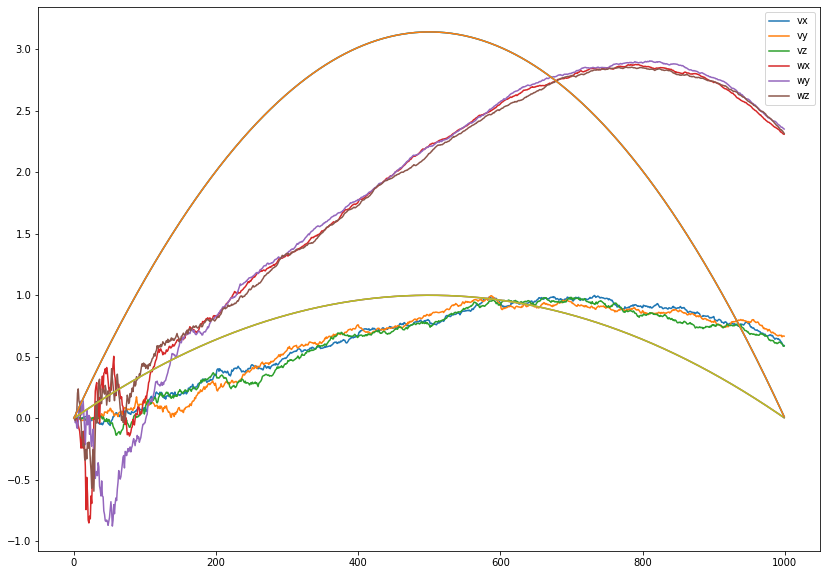

In [362]:
plt.plot(filter_v[:])
plt.plot(velocity_datas[:])
plt.legend(["vx", "vy", "vz", "wx", "wy", "wz"])
plt.show()
# data[0]

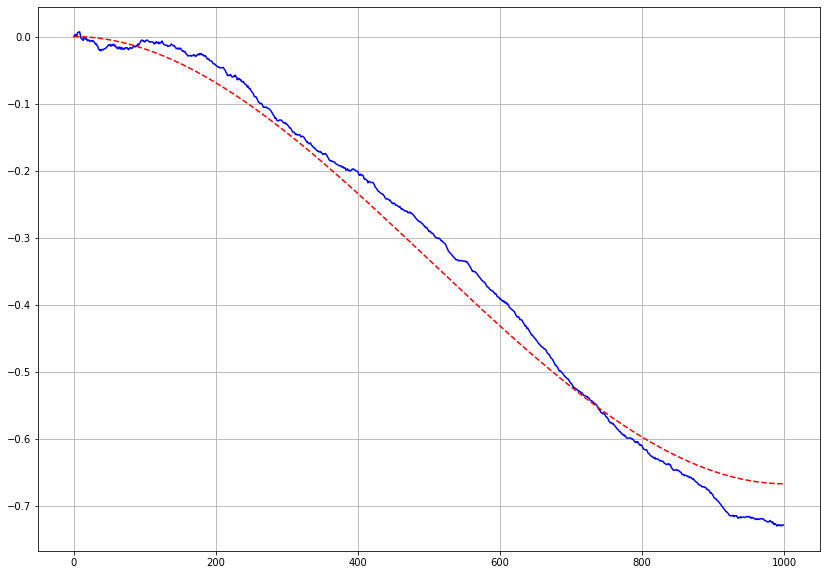

In [357]:
plt.plot(filter_T[:, 1],"b")
plt.plot(track_coeff[:, 1],"r--")
# plt.plot(real_datas[:, 1],"x")
plt.grid(True)
plt.show()